## Carregando bibliotecas e dataset

In [1]:
library(scales)
library(dplyr)
library(ggplot2)
library(daltoolbox)
library(RColorBrewer)
library(GGally)
library(reshape)
library(corrplot)
library(WVPlots)
library(aplpack)
library(gridExtra)
library(tidyr)
library(factoextra)
library(dbscan)
library(fpc)

options(scipen = 999)
colors <- brewer.pal(4, 'Set1')
font <- theme(text = element_text(size=16))
load("/home/data/malaria/malaria.RData")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘daltoolbox’


The following object is masked from ‘package:base’:

    transform


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


corrplot 0.92 loaded

Loading required package: wrapr


Attaching package: ‘wrapr’


The following object is masked from ‘package:dplyr’:

    coalesce


Warning message:
“no DISPLAY variable so Tk is not available”

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘tidyr’


The following objects are masked from ‘package:wrapr’:

    pack, un

## Explorando os dados
Todos os atributos são categóricos, exceto qty.parasites

In [2]:
glimpse(data)
print(t(sapply(data, class)))

Rows: 22,923,977
Columns: 40
$ infection.county      <fct> 110001, 110001, 110001, 110001, 110001, 110001, …
$ home.county           <fct> 110001, 110001, 110001, 110001, 110001, 110001, …
$ notification.county   <fct> 110001, 110001, 110001, 110001, 110001, 110001, …
$ qty.parasites         <dbl> 501100, NA, NA, NA, 3, 305500, NA, NA, NA, 50110…
$ scheme                <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 99, 1, 1, 1,…
$ notification.hr       <fct> ZONA DA MATA, ZONA DA MATA, ZONA DA MATA, ZONA D…
$ home.hr               <fct> ZONA DA MATA, ZONA DA MATA, ZONA DA MATA, ZONA D…
$ infection.hr          <fct> ZONA DA MATA, ZONA DA MATA, ZONA DA MATA, ZONA D…
$ exam.type             <fct> thick and thin blood smears, thick and thin bloo…
$ exam.result           <fct> vivax, vivax, vivax, vivax, vivax, vivax, vivax,…
$ gender                <fct> male, male, male, male, female, male, female, ma…
$ hemiparasite          <fct> negative, not researched, negative, not research…
$ symptom  

## Pré-processamento

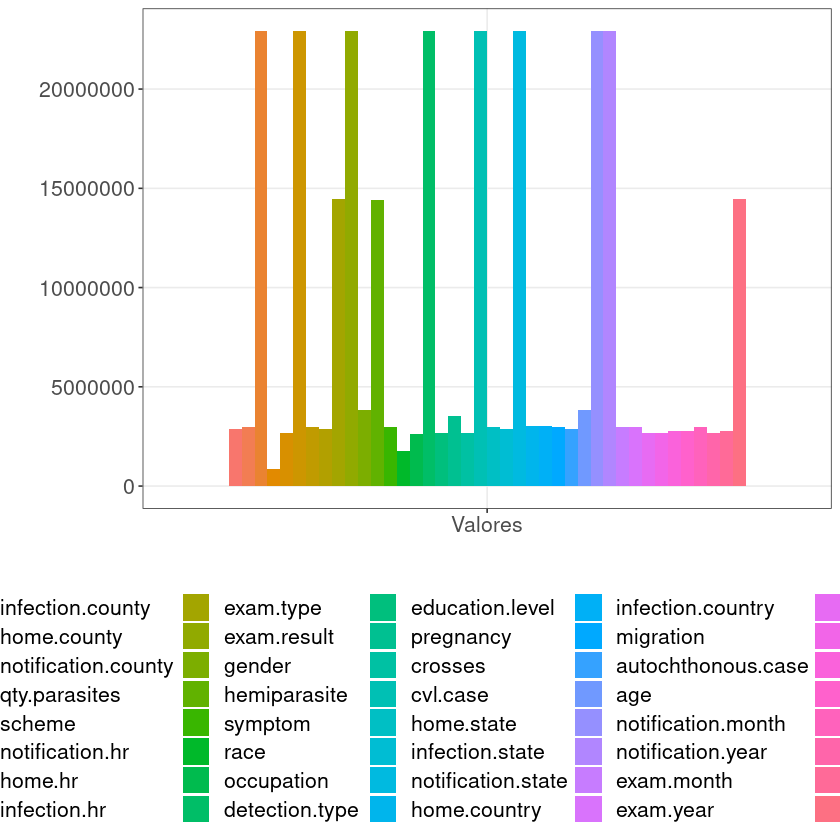

In [3]:
data.na <- na.omit(data)
#22923977/466127 = 49.17968     >> Só 2% dos dados são mantidos
results_list <- list()
for (feature in data) {
  x <- na.omit(feature)
  results_list <- append(results_list, list(x))
}

num_itens <- list()
for (feature in results_list) {
  x <- length(feature)
  num_itens <- append(num_itens, x)
}

feature_names <- names(data)
check_df <- data.frame(matrix(unlist(num_itens), ncol = length(num_itens), byrow = FALSE))
colnames(check_df) <- feature_names
new_column <- c("Valores") #Casa de Ferreiro
check_df <- data.frame(NewColumnName = new_column, check_df) #Espeto de Pau
grf <- plot_groupedbar(check_df) + font #Não conseguiu plotar 40 colres
plot(grf)

### Problema dos dados nulos

### Separando os grupos
Percepção de quais features tinha mais ou menos nulos.
Separação em 2 grupos (mais nulos e menos nulos).

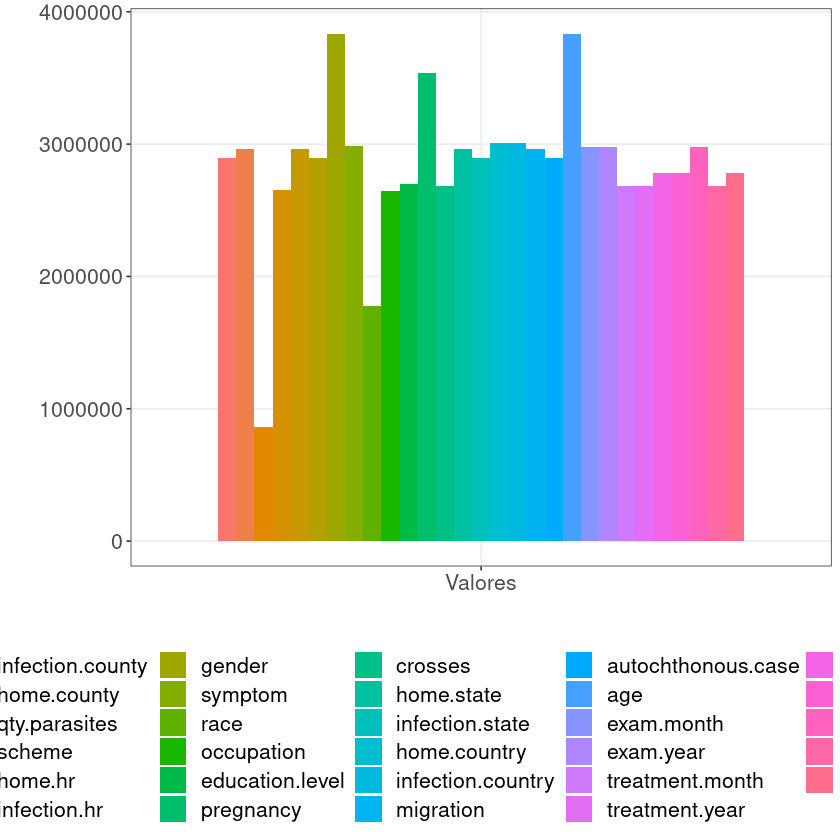

In [4]:
pequenos <- c("notification.hr", "notification.county", "exam.type", "exam.result",
             "hemiparasite", "detection.type", "cvl.case", "notification.state",
             "notification.month", "notification.year", "previous.treatment")

# Delete columns by excluding them using negative index
check_df_pequeno <- check_df[, !names(check_df) %in% pequenos]
grf2 <- plot_groupedbar(check_df_pequeno) + font #Não conseguiu plotar 40 colres
plot(grf2)

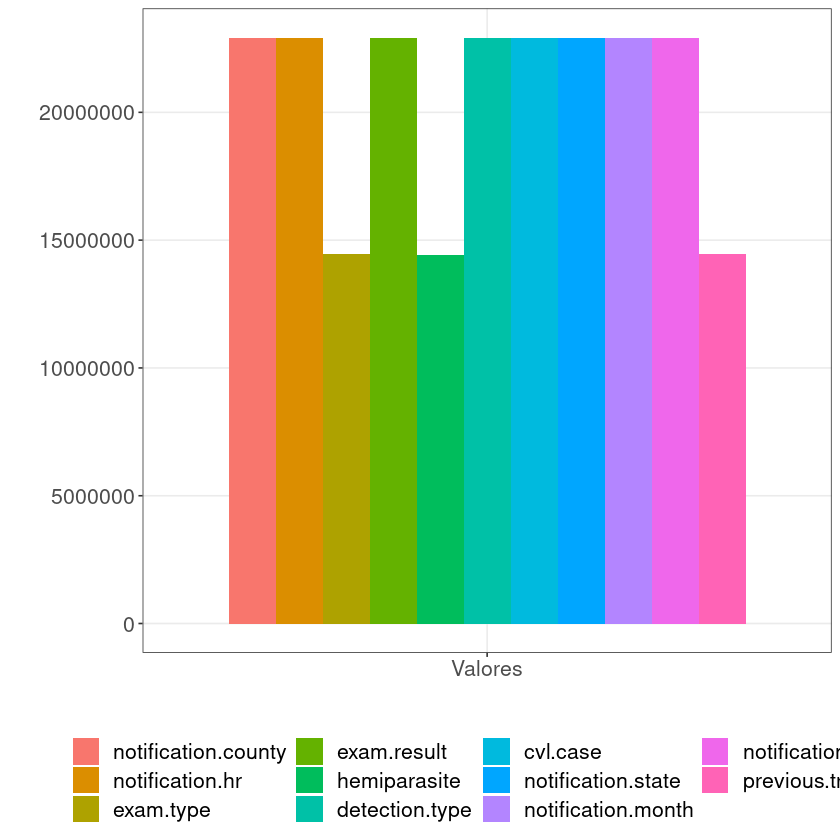

In [5]:
grandes <- c("NewColumnName", "notification.hr", "notification.county", "exam.type",
             "exam.result",
             "hemiparasite", "detection.type", "cvl.case", "notification.state",
             "notification.month", "notification.year", "previous.treatment")

check_df_grande <- check_df[, names(check_df) %in% grandes]
grf3 <- plot_groupedbar(check_df_grande) + font #Não conseguiu plotar 40 colres
plot(grf3)

In [6]:
#Criando o grupo 1
grupo_grande <- c("notification.hr", "notification.county", "exam.type","exam.result",
              "hemiparasite", "detection.type", "cvl.case", "notification.state",
              "notification.month", "notification.year", "previous.treatment")
grupo_1 <- na.omit( data[, names(data) %in% grupo_grande] )

#Criando o grupo 2
grupo_pequeno <- c("race", "qty.parasites")
grupo_2 <- na.omit( data[, !names(data) %in% grupo_pequeno] )

## Predictions

### Criando grupos de datasets para treinamentos de previsão

In [7]:
#Dataset Grupo 1
set.seed(1)
sr1 <- sample_random()
sr1 <- train_test(sr1, grupo_1)
sr1_train <- sr1$train
sr1_test <- sr1$test
slevels <- levels(grupo_1$exam.result)

#Dataset Grupo 2
sr2 <- sample_random()
sr2 <- train_test(sr2, grupo_2)
sr2_train <- sr2$train
sr2_test <- sr2$test
slevels2 <- levels(grupo_2$exam.result)

### Majority test - Grupo 1

### Majority test - Grupo 2

In [10]:
#Majority treinamento grupo 2
model <- cla_majority("exam.result", slevels2)
model <- fit(model, sr2_train)
train_prediction <- predict(model, sr2_train)
train_predictand <- adjust_class_label(sr2_train[,"exam.result"])
train_eval <- evaluate(model, train_predictand, train_prediction)

metricas <- data.frame(
  name = "train_g2",
  accuracy = train_eval$accuracy,
  f1 = train_eval$f1,
  sensitivity = train_eval$sensitivity,
  specificity = train_eval$specificity,
  precision = train_eval$precision,
  recall = train_eval$recall
)
#metricas <- rbind(metricas, new_row)

test_prediction <- predict(model, sr2_test)
test_predictand <- adjust_class_label(sr2_test[,"exam.result"])
test_eval <- evaluate(model, test_predictand, test_prediction)

new_row <- data.frame(
  name = "test_g2",
  accuracy = test_eval$accuracy,
  f1 = test_eval$f1,
  sensitivity = test_eval$sensitivity,
  specificity = test_eval$specificity,
  precision = test_eval$precision,
  recall = test_eval$recall
)
metricas <- rbind(metricas, new_row)

name,accuracy,f1,sensitivity,specificity,precision,recall
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
train_g2,0.9804847,0.8926657,0.8926657,0.9892666,0.8926657,0.8926657
test_g2,0.9805013,0.8927572,0.8927572,0.9892757,0.8927572,0.8927572


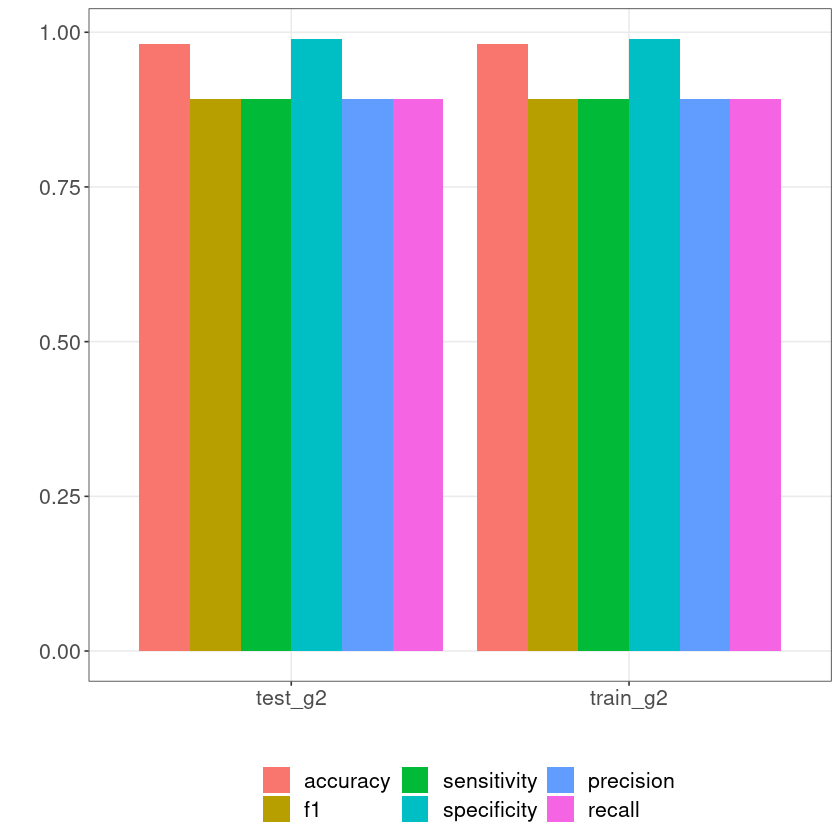

In [12]:
metricas
grf <- plot_groupedbar(metricas) + font
plot(grf)

In [ ]:
### 

## Reconhecimento de padrões

### Verificar se existe alguma relacao para os resultados vivax e falciparum em relação aos dados demográficos

In [4]:
# pré-processamento
# selecionando os resultados vivax e falciparum e os atributos demográficos

ds1 <- data %>% filter(exam.result=="vivax" | exam.result == "falciparum")
ds1 <- ds1 %>% select(exam.result,gender,age,race,occupation,education.level,pregnancy,autochthonous.case)

# preparando dataset
# separando amostras de treino e teste

slevels <- levels(ds1$exam.result)
set.seed(1)
sr <- sample_random()
sr <- train_test(sr, ds1)
ds1_train <- sr$train
ds1_test <- sr$test

# juntando dados em uma tabela para melhor vizualização da distribuição

tbl <- rbind(table(ds1[,"exam.result"]), 
             table(ds1_train[,"exam.result"]), 
             table(ds1_test[,"exam.result"]))
rownames(tbl) <- c("dataset", "training", "test")
head(tbl)

,negative,falciparum,F+FG,vivax,F+V,V+FG,FG,malariae,F+M,ovale,non falciparum
dataset,0,262440,0,2365980,0,0,0,0,0,0,0
training,0,210093,0,1892643,0,0,0,0,0,0,0
test,0,52347,0,473337,0,0,0,0,0,0,0


In [5]:
# Modelo de Treino
model <- cla_dtree("exam.result", slevels)
model <- fit(model, ds1_train)
train_prediction <- predict(model, ds1_train)

In [6]:
# Modelo de Avaliação
ds1_train_predictand <- adjust_class_label(ds1_train[,"exam.result"])
train_eval <- evaluate(model, ds1_train_predictand, train_prediction)
print(train_eval$metrics)

   accuracy        f1 sensitivity specificity precision    recall
1 0.9818338 0.9000859   0.9000859   0.9900086 0.9000859 0.9000859


In [7]:
# Realização de Testes
test_prediction <- predict(model, ds1_test)
  
ds1_test_predictand <- adjust_class_label(ds1_test[,"exam.result"])
test_eval <- evaluate(model, ds1_test_predictand, test_prediction)
print(test_eval$metrics)

   accuracy        f1 sensitivity specificity precision    recall
1 0.9818948 0.9004212   0.9004212   0.9900421 0.9004212 0.9004212
